### Data Prep

Loading the token-wise surprisals, aligning them with the word-level RTs, and computing predictors. Length & log frequency are control predictors, and we also add the previous token's surprisal, length, and frequency to control for spill-over effects. Exclude OOV items and items before/after punctuation/non-alphabetical tokens.

In [1]:
import json
import numpy as np
import pandas as pd
from src.tokenization_analysis import *

Align surprisals with RTs, generate predictors for each tokenization scheme for Dundee corpus data

In [2]:
rt_data = "data/processed_rts/dundee_rts.csv"
orth = "data/surprisal_data/dundee/baseline.csv"
bpe = "data/surprisal_data/dundee/bpe.csv"
morph = "data/surprisal_data/dundee/morph_surprisal.csv"

rts = preprocess_rt_data(rt_data)
model_config = json.load(open("model_config.json"))

orth_data = process_surprisal_data(rts, orth, model_config['orth'], 'dundee')
bpe_data = process_surprisal_data(rts, bpe, model_config['bpe'], 'dundee')
morph_data = process_surprisal_data(rts, morph, model_config['transducer'], 'dundee', use_lookup = True)
# different items would be OOV under different tokenization schemes, this makes sure we compare the same dataset

common_index = orth_data.index.intersection(bpe_data.index).intersection(morph_data.index)
dundee_all = combine_corpus_data([orth_data, bpe_data, morph_data], ['orthographic', 'bpe', 'morphological'], common_index)
dundee_all['corpus'] = "dundee"

/Users/sathvik/Desktop/umd/tokenization/src/tokenization_analysis.py:89: FutureWarning: The default value of regex will change from True to False in a future version.
  rts["token"] = rts["token"].str.replace('[^\w\s]','')
/Users/sathvik/Desktop/umd/tokenization/src/tokenization_analysis.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surprisal_rts['tokenization'] = col_name


Running the same steps for the Natural Stories corpus

In [3]:
rt_data = "data/processed_rts/natural_stories_rts.csv"
orth = "data/surprisal_data/natural_stories/orthographical_surprisal.csv"
bpe = "data/surprisal_data/natural_stories/bpe_surprisal.csv"
morph = "data/surprisal_data/natural_stories/morph_surprisal.csv"

rts = preprocess_rt_data(rt_data)
model_config = json.load(open("model_config.json"))

orth_data = process_surprisal_data(rts, orth, model_config['orth'], 'natural_stories', prev_tokens = 3)
bpe_data = process_surprisal_data(rts, bpe, model_config['bpe'], 'natural_stories', prev_tokens = 4)
morph_data = process_surprisal_data(rts, morph, model_config['transducer'], 'natural_stories', prev_tokens = 4, use_lookup = True)

common_index = orth_data.index.intersection(bpe_data.index).intersection(morph_data.index)
ns_all = combine_corpus_data([orth_data, bpe_data, morph_data], ['orthographic', 'bpe', 'morphological'], common_index)
ns_all['corpus'] = "natural_stories"

Writing the data from both corpora to a CSV to run regression models in R

In [4]:
combined_surprisal_rts = pd.concat([dundee_all, ns_all])

combined_surprisal_rts.to_csv("data/surprisal_data/combined_surprisal_rts.csv", index = False)

## Analyzing Large Differences between Morphological and BPE-based Surprisal

We look for words where the morphological tokenization-based LM had a much lower surprisal than the BPE-based one.

In [5]:
data = combined_surprisal_rts[['token', 'surprisal', 'transcript_id', 'sentence_id', 'corpus', 'tokenization']]
bpe_data = data[data['tokenization'] == 'bpe']
morph_data = data[data['tokenization'] == 'morphological']
morph_data['surprisal_diff'] = morph_data['surprisal'] - bpe_data['surprisal']
sorted_morph = morph_data.sort_values('surprisal_diff')

/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Looking for examples in the Natural Stories corpus, *bulbs* is the multi-morphemic word with the biggest difference in surprisal.

In [6]:
sorted_morph[sorted_morph['corpus'] == 'natural_stories'].head()

,token,surprisal,transcript_id,sentence_id,corpus,tokenization,surprisal_diff
3064,late,6.479430,1,147,natural_stories,morphological,-9.824081
8427,bulbs,7.834730,1,411,natural_stories,morphological,-9.469359
9433,condition,5.591241,1,457,natural_stories,morphological,-9.368578
8000,nineteen,10.876982,1,397,natural_stories,morphological,-8.341291
5874,hard,7.184825,1,292,natural_stories,morphological,-8.097639


The sentence has *tulip bulbs*, so it is possible the BPE-based tokenizer may not have picked up on this frequently occurring bigram.

In [7]:
def show_sentence(df, sent_id, transcript_id, corpus_name):
    sentence_tokens = df[(df['sentence_id'] == sent_id) & (df['transcript_id'] == transcript_id) & (df['corpus'] == corpus_name)]['token']
    return ' '.join(sentence_tokens)

In [8]:
sent = show_sentence(morph_data, 411, 1, "natural_stories")
sent

'planted his collection of tulip bulbs that sent to him were able to tolerate the harsher conditions of the'

We now compare how this sentence looks under different tokenization schemes and visualize the results.

In [9]:
tulips = morph_data[morph_data['sentence_id'] == 411].reset_index()
tulips[tulips['token'] == 'bulbs'].index

Int64Index([5], dtype='int64')

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from src.morph_segmenter import load_model_and_vocab, tokenize_sentence
from transformers import AutoTokenizer

sns.set_theme(style = 'darkgrid')

def visualize_morph_bpe_surprisal_diff(bpe, morph, sent_id, transcript_id, corpus_name, word):
    # show how the sentence is tokenized
    bpe_tokenizer = AutoTokenizer.from_pretrained('gpt2')
    transducer, transducer_vocab = load_model_and_vocab("sigmorphon_model/model/")
    print(sent + "\n" + "BPE:")
    bpe_sent = " ".join(bpe_tokenizer.tokenize(sent))
    print(bpe_sent + "\n" + "Morphological: ")
    morph_sent = " ".join(tokenize_sentence(transducer, transducer_vocab, sent, "↓")[0])
    print(morph_sent)
    
    word_morph = extract_one_sentence(morph, sent_id, corpus_name, transcript_id)
    word_bpe = extract_one_sentence(bpe, sent_id, corpus_name, transcript_id)
    
    # in case we get a really long sentence, the most we want to focus on is the five words before & after the target word
    ngram_order = 5
    word_morph = word_morph.reset_index()
    word_bpe = word_bpe.reset_index()
    word_index = word_morph[word_morph['token'] == word].index.values[0]
    start = max(0, word_index - ngram_order)
    end = min(len(word_morph.index), word_index + ngram_order)
    word_morph, word_bpe = word_morph.iloc[start:end], word_bpe.iloc[start:end]
    
    # plotting
    ind = np.arange(end - start)
    palette = sns.color_palette("Dark2")
    width = 0.35
    fig, ax = plt.subplots(figsize = (18, 8))
    ax.bar(ind, word_morph['surprisal'], width, label = "Segmented Morphemes", color = palette[0])
    ax.bar(ind + width, word_bpe['surprisal'], width, label = "BPE", color = palette[2])
    ax.set_xticks(ind)
    ax.set_xticklabels(word_morph['token'].values)
    ax.set_ylabel("Surprisal")
    plt.legend()
    plt.show()

planted his collection of tulip bulbs that sent to him were able to tolerate the harsher conditions of the
BPE:
pl anted Ġhis Ġcollection Ġof Ġtul ip Ġbulbs Ġthat Ġsent Ġto Ġhim Ġwere Ġable Ġto Ġtolerate Ġthe Ġharsher Ġconditions Ġof Ġthe
Morphological: 
↓plant ed ↓his ↓collect ion ↓of ↓tulip ↓bulb s ↓that ↓sent ↓to ↓him ↓were ↓able ↓to ↓tolerate ↓the ↓harsh er ↓condition s ↓of ↓the


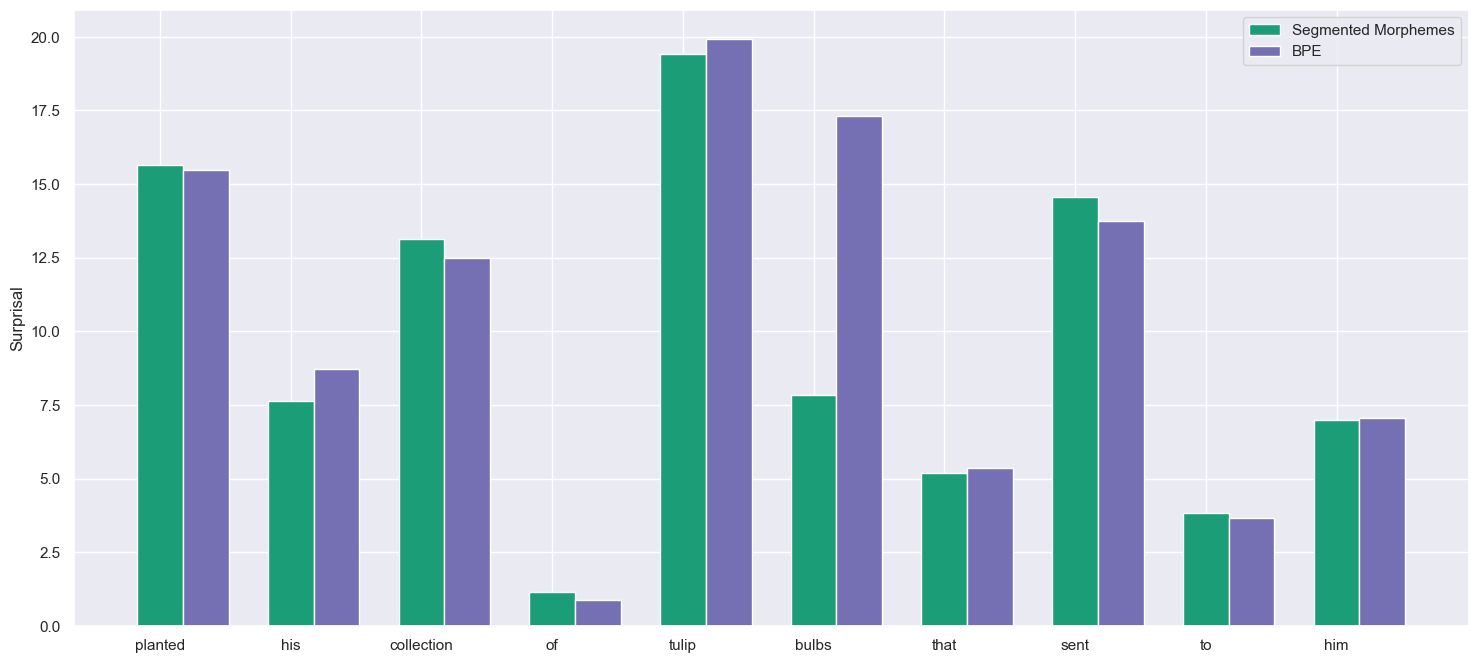

In [15]:
visualize_morph_bpe_surprisal_diff(bpe_data, morph_data, 411, 1, "natural_stories", "bulbs")

Repeating our analysis for words in the Dundee corpus

In [16]:
sorted_morph[sorted_morph['corpus'] == 'dundee'].head()

,token,surprisal,transcript_id,sentence_id,corpus,tokenization,surprisal_diff
41526,gagarin,22.696480,7,16,dundee,morphological,-14.953188
2613,embryology,19.352882,3,0,dundee,morphological,-14.573388
46420,embryology,19.370683,6,8,dundee,morphological,-14.555586
46339,embryology,19.370683,6,5,dundee,morphological,-14.555586
29605,saeed,9.179002,14,64,dundee,morphological,-14.035922


The morphological transducer treates *embryology* as a whole word and *gagarin* and *saeed* are proper names. This difference may have to do with how the tokens are split up. Instead, we pick *carefully* (34th most negative morphological vs. BPE surprisal difference in the Dundee corpus). It consists of multiple segments instead of a single word with a prefix or suffix.

In [17]:
sorted_morph[sorted_morph['corpus'] == 'dundee'][30:40]

,token,surprisal,transcript_id,sentence_id,corpus,tokenization,surprisal_diff
27656,stable,9.004187,8,85,dundee,morphological,-7.831474
32168,stakeholder,15.600091,4,52,dundee,morphological,-7.760412
20334,richard,8.488529,1,112,dundee,morphological,-7.729669
19074,carefully,7.869497,1,51,dundee,morphological,-7.720871
45348,effect,6.348611,20,76,dundee,morphological,-7.711471
26812,associate,8.132791,8,41,dundee,morphological,-7.710861
40610,speaker,7.985207,17,99,dundee,morphological,-7.702006
21414,reasonable,3.114220,11,41,dundee,morphological,-7.554686
20369,richard,8.488529,1,113,dundee,morphological,-7.489741
39902,see,6.570640,17,60,dundee,morphological,-7.476445


In [18]:
sent = show_sentence(morph_data, 51, 1, 'dundee')
sent

'lies in treading carefully wherever we'

lies in treading carefully wherever we
BPE:
lies Ġin Ġtread ing Ġcarefully Ġwherever Ġwe
Morphological: 
↓lie s ↓in ↓tread ing ↓care ful ly ↓where ever ↓we


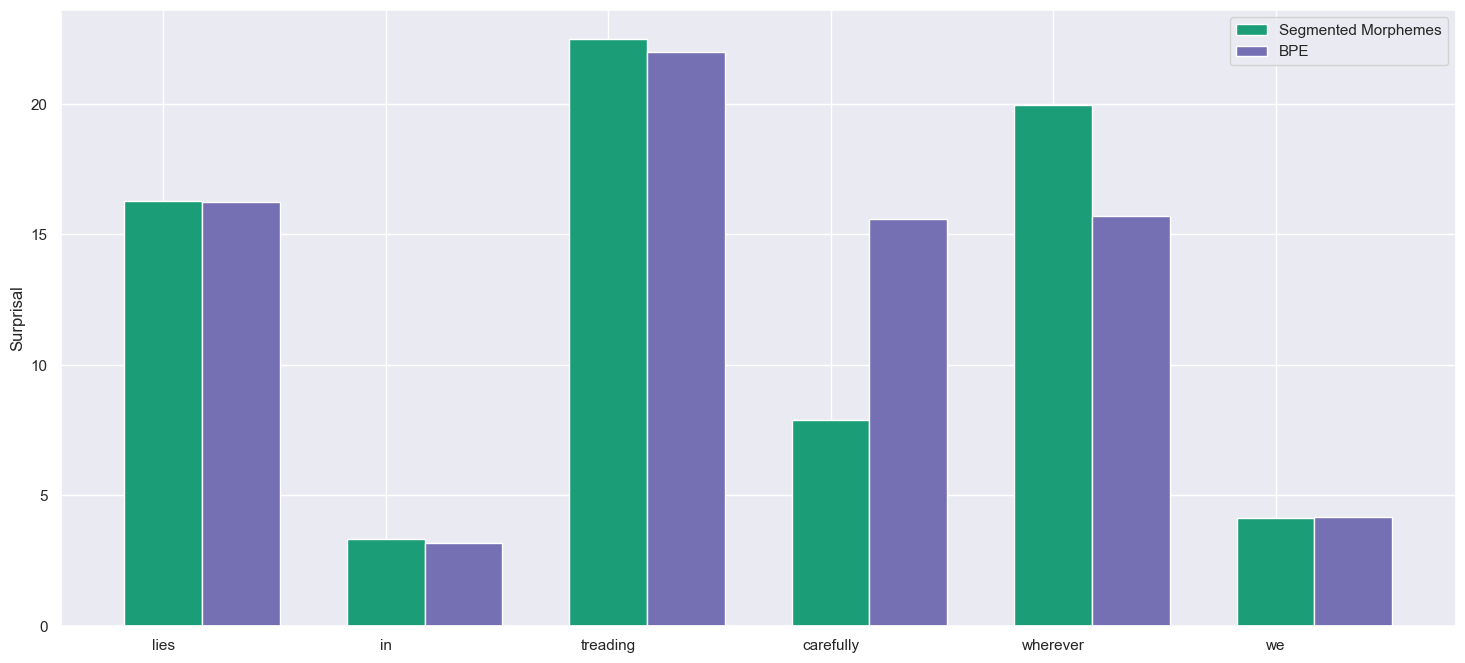

In [19]:
visualize_morph_bpe_surprisal_diff(bpe_data, morph_data, 51, 1, "dundee", "carefully")

### Exploring differences in surprisal distributions

(-5.0, 35.0)

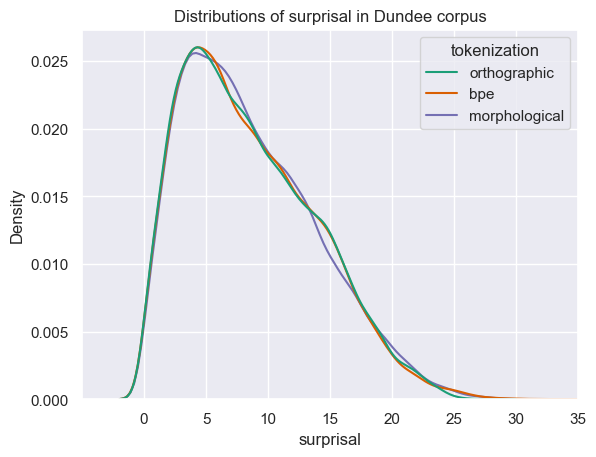

In [20]:
sns.kdeplot(x = 'surprisal', hue = 'tokenization', data = dundee_all, palette = "Dark2")
plt.title("Distributions of surprisal in Dundee corpus")
plt.xticks(np.arange(0, 36, 5))
plt.xlim(-5, 35)

(-5.0, 35.0)

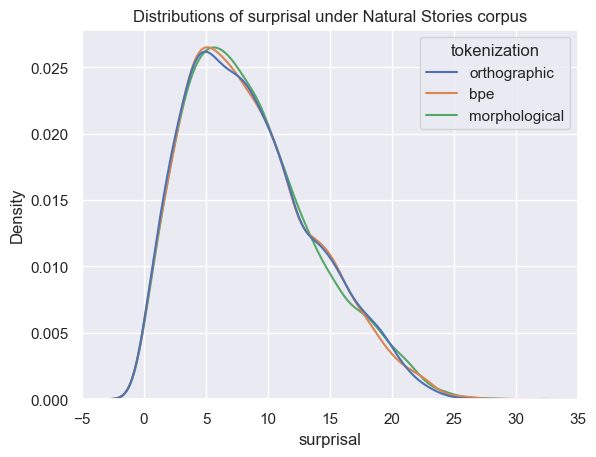

In [22]:
sns.kdeplot(x = 'surprisal', hue = 'tokenization', data = ns_all)
plt.title("Distributions of surprisal under Natural Stories corpus")
plt.xlim(-5, 35)